In [86]:
# traditional imports 
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from collections import defaultdict
import json
import matplotlib.cm as cm
import scipy as sp
from matplotlib import rcParams
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def remove_border(axes = None, left = True, bottom = True, right = False, top = False):
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['bottom'].set_visible(bottom)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now reenable them accordingily 
    
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)        

#### Dataset
The data set has been extracted from the Yelp Phoenix restaurants dataset. The dataset is about the reviews, but the data of users and businesses has been joined.... so that we want to work on the single dataset.

In [3]:
df = pd.read_csv("data/bigdf.csv")
df.head()

,user_id,business_id,date,review_id,stars,usefulvotes_review,user_name,categories,biz_name,latitude,longitude,business_avg,business_review_count,user_avg,user_review_count
0,rLtl8ZkDX5vH5nAx9C3q5Q,9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,5,Jason,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.796954,197
1,SBbftLzfYYKItOMFwOTIJg,9yKzy9PApeiPPOUJEtnvkg,2008-05-04 00:00:00,DASdFe-g0BgfN9J2tanStg,5,1,Jennifer,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.473684,57
2,mlBC3pN9GXlUUfQi1qBBZA,9yKzy9PApeiPPOUJEtnvkg,2010-07-05 00:00:00,W8CX2h_hmODWmgSJVbMifw,2,1,Jennifer,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.702381,84
3,0bNXP9quoJEgyVZu9ipGgQ,9yKzy9PApeiPPOUJEtnvkg,2012-10-10 00:00:00,nYVQiPGeiwr7g5BSX7WDJg,3,9,Aileen,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.180077,261
4,T7J9ae0wTskrI_Bgwp-4cA,9yKzy9PApeiPPOUJEtnvkg,2009-12-17 00:00:00,grZNCXAgd-OH8daA28R-2A,3,1,Jasmine,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.343284,201


## EDA

In [4]:
df.dtypes

user_id                   object
business_id               object
date                      object
review_id                 object
stars                      int64
usefulvotes_review         int64
user_name                 object
categories                object
biz_name                  object
latitude                 float64
longitude                float64
business_avg             float64
business_review_count      int64
user_avg                 float64
user_review_count          int64
dtype: object

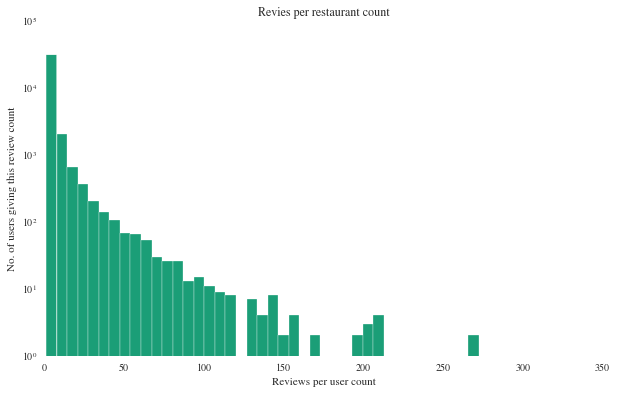

In [5]:
#we need a series object...
df_user_revcount = df.groupby('user_id').review_id.count()
#bins is grouping on the x axis 
ax = df_user_revcount.hist(bins=50, log=True)  
remove_border(ax)
plt.xlabel("Reviews per user count")
plt.ylabel("No. of users giving this review count")
plt.grid(False)
plt.grid(axis = 'y', color = 'white', linestyle = '-')
plt.title("Revies per restaurant count")

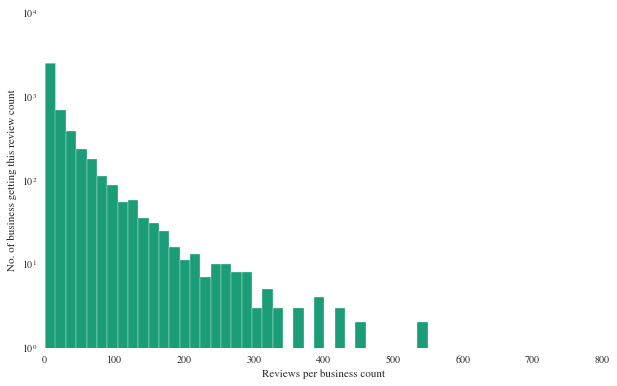

In [6]:
df_business_count = df.groupby('business_id').review_id.count()
ax = df_business_count.hist(bins = 50, log = True)
remove_border(ax)
plt.grid(False)
plt.grid(axis = 'y', color = 'white', linestyle = '-')
plt.xlabel("Reviews per business count")
plt.ylabel("No. of business getting this review count")

In [7]:
"Users", len(df.user_id.unique()), "businesses", len(df.business_id.unique())

('Users', 34789, 'businesses', 4503)

#### There are more users than businesses!

What we see is intuitive, that is, less number of reviews are given be less users, very few users are kind of dedicated reviewing the movies, what we can extract is for example, users having more interest in the movies. Same goes for the number of businesses, but what we can extract is, the businesses having more number of reviews are less which tells us that there are very few businesses which are good or which may be have good approaches? 

Now we'll compute the average - 

In [8]:
#mean revies given by the users
df.stars.mean()

3.7414126802349332

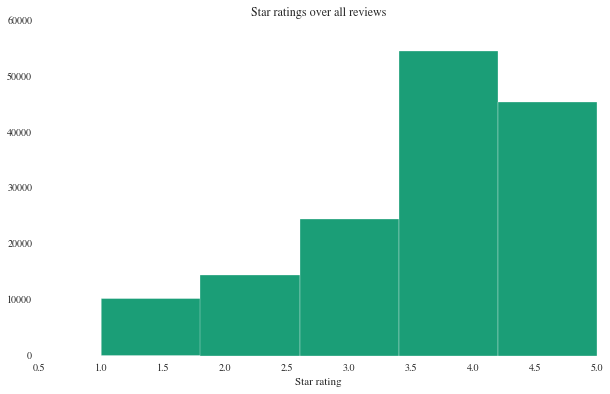

In [9]:
#important plotting strategy
stars = df.stars 
ax=stars.hist(bins=5)
remove_border(ax)
plt.xlabel("Star rating")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Star ratings over all reviews")

What we see is that most of the reviews are between 3.5 and 4 which is again, intuitive.

In [10]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all averages and review counts recomputed
    this is used when a frame is subsetted.
    """
    ldfu=ldf.groupby('user_id')
    ldfb=ldf.groupby('business_id')
    user_avg=ldfu.stars.mean()
    user_review_count=ldfu.review_id.count()
    business_avg=ldfb.stars.mean()
    business_review_count=ldfb.review_id.count()
    #copy the dataframe
    nldf=ldf.copy()
    nldf.set_index(['business_id'], inplace=True)
    nldf['business_avg']=business_avg
    nldf['business_review_count']=business_review_count
    nldf.reset_index(inplace=True)
    nldf.set_index(['user_id'], inplace=True)
    nldf['user_avg']=user_avg
    nldf['user_review_count']=user_review_count
    nldf.reset_index(inplace=True)
    return nldf

In [11]:
#smaller dataset meeting some of the conditions 
smallidf = df[(df.user_review_count > 60) & (df.business_review_count > 150)]
smalldf = recompute_frame(smallidf)
smalldf.head()

,user_id,business_id,date,review_id,stars,usefulvotes_review,user_name,categories,biz_name,latitude,longitude,business_avg,business_review_count,user_avg,user_review_count
0,rLtl8ZkDX5vH5nAx9C3q5Q,eIxSLxzIlfExI6vgAbn2JA,2011-05-12 00:00:00,z4G1g3VcdfigCUtVDFRL1w,4,5,Jason,"[Burgers, Hot Dogs, American (New), Restaurants]",Lobbys Beef Burgers Dogs,33.39477,-111.908894,4.04,25,3.709677,62
1,C6IOtaaYdLIT5fWd7ZYIuA,eIxSLxzIlfExI6vgAbn2JA,2011-04-12 00:00:00,480M-xDpRaA1gCVCqIG4WA,4,14,Daren,"[Burgers, Hot Dogs, American (New), Restaurants]",Lobbys Beef Burgers Dogs,33.39477,-111.908894,4.04,25,4.000000,15
2,mlBC3pN9GXlUUfQi1qBBZA,eIxSLxzIlfExI6vgAbn2JA,2011-09-17 00:00:00,q_T6FtScTul_yYIGyrgTxA,3,0,Jennifer,"[Burgers, Hot Dogs, American (New), Restaurants]",Lobbys Beef Burgers Dogs,33.39477,-111.908894,4.04,25,3.750000,12
3,T7J9ae0wTskrI_Bgwp-4cA,eIxSLxzIlfExI6vgAbn2JA,2011-03-09 00:00:00,YPKedK7JuKC36cDAKuDGTQ,3,2,Jasmine,"[Burgers, Hot Dogs, American (New), Restaurants]",Lobbys Beef Burgers Dogs,33.39477,-111.908894,4.04,25,3.696970,33
4,nbofxFWHORebBHh10OgYLA,eIxSLxzIlfExI6vgAbn2JA,2011-07-28 00:00:00,y7yBnfbPxZJ_L93tnxMP3g,2,1,Christopher,"[Burgers, Hot Dogs, American (New), Restaurants]",Lobbys Beef Burgers Dogs,33.39477,-111.908894,4.04,25,3.833333,12


In [12]:
smalldf.user_id.unique().shape[0], smalldf.business_id.unique().shape[0]

(240, 172)

The number of users and the number of businesses have drastically reduced which means that mostly the users tend to give less than total 60 reivies on the site... 

In [13]:
smalldf.stars.mean()
#the mean hasn't changed much though

3.867639902676399

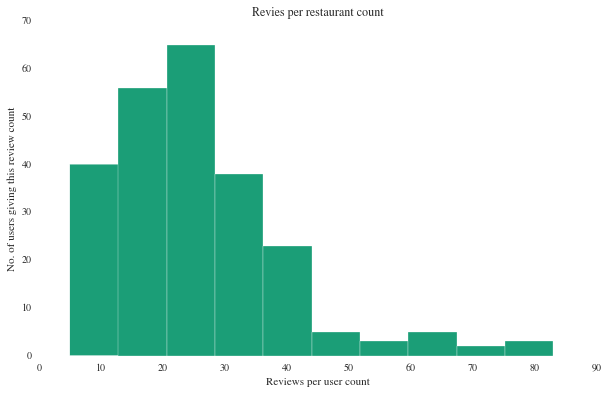

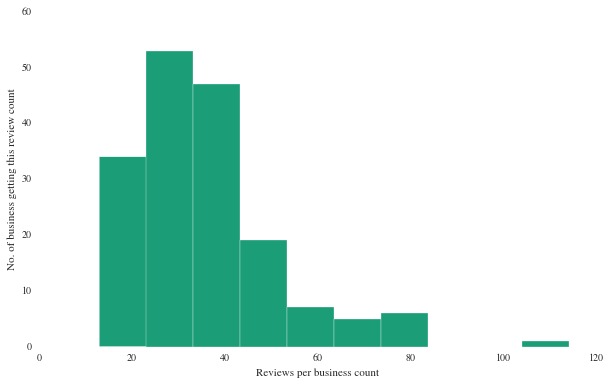

In [14]:
#what we'll get is a less sparse histogram
#we need a series object...
smalldf_user_revcount = smalldf.groupby('user_id').review_id.count()
#bins is grouping on the x axis 
plt.figure()
ax = smalldf_user_revcount.hist()  
remove_border(ax)
plt.xlabel("Reviews per user count")
plt.ylabel("No. of users giving this review count")
plt.grid(False)
plt.grid(axis = 'y', color = 'white', linestyle = '-')
plt.title("Revies per restaurant count")
plt.figure()
smalldf_business_count = smalldf.groupby('business_id').business_review_count.count()
ax = smalldf_business_count.hist()
remove_border(ax)
plt.grid(False)
plt.grid(axis = 'y', color = 'white', linestyle = '-')
plt.xlabel("Reviews per business count")
plt.ylabel("No. of business getting this review count")

3.867639902676399

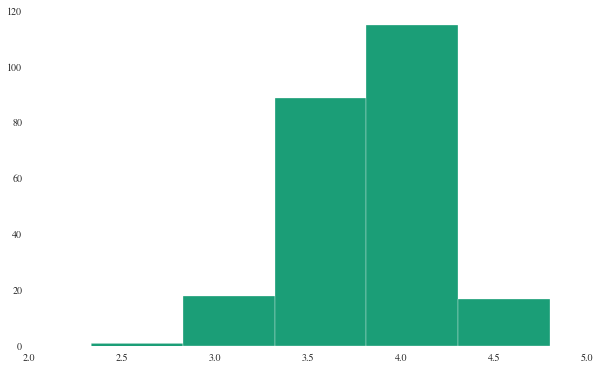

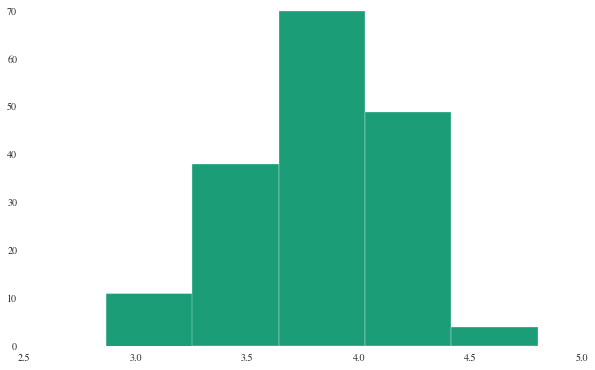

In [15]:
#the reviews being provided by the users
avg_usr_rating = smalldf.groupby('user_id').stars.mean()
ax = avg_usr_rating.hist(bins = 5)
plt.figure()
#the number of businesses receiving that much reviews vs the review.
avg_business_rating = smalldf.groupby('business_id').stars.mean()
ax = avg_business_rating.hist(bins = 5)
smalldf.stars.mean()

## Common Support

Mean support is: 6.84679722562


(array([  7.02000000e+03,   4.98700000e+03,   1.79400000e+03,
          5.90000000e+02,   1.95000000e+02,   7.60000000e+01,
          2.20000000e+01,   1.00000000e+01,   1.00000000e+01,
          2.00000000e+00]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ]),
 <a list of 10 Patch objects>)

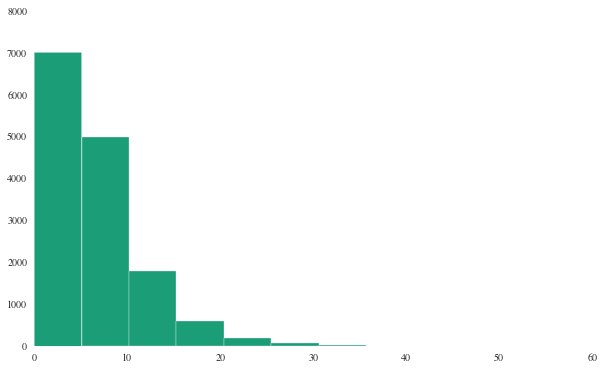

In [16]:
# evaluating the common support - means the number of users giving rating to the same 
# business or rest...
restaurants = smalldf.business_id.unique()
supports = []
for i, rest1 in enumerate(restaurants):
    for j, rest2 in enumerate(restaurants):
        if i < j:
            user_1 = smalldf[smalldf.business_id == rest1].user_id.unique()
            user_2 = smalldf[smalldf.business_id == rest2].user_id.unique()
            common_reviewers = set(user_1).intersection(user_2)
            supports.append(len(common_reviewers))
print ("Mean support is:",np.mean(supports))
plt.hist(supports)       

As you can see, even though we chose a subset of the dataframe in which every restaurant had 150 reviews and every user had atleast made 60, the common support of most pairs of restaurants is really low, indeed less than 10!.

### Calculating Similarity

What we are actually doing is calculating the similarity on the basis of to what degree the common users have rated the restaurants, and we do this by using the pearson's coefficient. 

In [17]:
#pearson coefficient or pearson product moment correlation(PPMC) is for measuring 
#the correlation between two variables is - covariance(X, Y) / std_dev(X) * std_dev(Y)
from scipy.stats.stats import pearsonr
def pearson_sim(rest1_reviews, rest2_reviews, n_common):
    """
    Given a subframe of restaurant 1 reviews and a subframe of restaurant 2 reviews,
    where the reviewers are those who have reviewed both restaurants, return 
    the pearson correlation coefficient between the user average subtracted ratings.
    The case for zero common reviewers is handled separately. Its
    ok to return a NaN if any of the individual variances are 0.
    """
    if n_common==0:
        rho=0.
    else:
        diff1=rest1_reviews['stars']-rest1_reviews['user_avg']
        diff2=rest2_reviews['stars']-rest2_reviews['user_avg']
        rho=pearsonr(diff1, diff2)[0]
    return rho

In [18]:
def get_restaurant_reviews(restaurant_id, df, set_of_users):
    """
    given a resturant id and a set of reviewers, return the sub-dataframe of their
    reviews.
    """
    #isin returns a boolean matrix checking whether the values are in the 
    #dataframe or not.
    #so get the users who have rated that business
    mask = (df.user_id.isin(set_of_users)) & (df.business_id==restaurant_id)
    reviews = df[mask]
    #remove the duplicate items
    reviews = reviews[reviews.user_id.duplicated()==False]
    #return the cleaned dataframe
    return reviews

In [19]:
#for checking the degree of similarity between two restaurants  
def calculate_similarity(rest1, rest2, df, similarity_func):
    #get the users who have reviewed both the restaurants
    users_rev_1 = df[df.business_id == rest1].user_id.unique()
    users_rev_2 = df[df.business_id == rest2].user_id.unique()
    users_inter = set(users_rev_1).intersection(users_rev_2)
    #now get the subdataframes containing info about those users
    get_rest1 = get_restaurant_reviews(rest1, df, users_inter)
    get_rest2 = get_restaurant_reviews(rest2, df, users_inter)
    #calculating the similarity using pearsons coefficient
    calc_sim = similarity_func(get_rest1, get_rest2, len(get_rest1))
    if np.isnan(calc_sim):
        return (0, len(get_rest1))
    return (calc_sim, len(get_rest1))

In [20]:
#testing, testing 1..2..3..
calculate_similarity("eIxSLxzIlfExI6vgAbn2JA", "bc-lE-wGVAsUrX-kJhtY-Q", smalldf, pearson_sim)

(0.20021785257950644, 5)

Our functions are ready, now we'll create the database storing the pairwise similarity of all the restaurants

### Making a database of similarities

In [21]:
class Database:
    "A class representing a database of similaries and common supports"
    
    def __init__(self, df):
        "the constructor, takes a reviews dataframe like smalldf as its argument"
        database={}
        self.df=df
        self.uniquebizids={v:k for (k,v) in enumerate(df.business_id.unique())}
        keys=self.uniquebizids.keys()
        l_keys=len(keys)
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys, l_keys], dtype=np.int)
        
    def populate_by_calculating(self, similarity_func):
        """
        a populator for every pair of businesses in df. takes similarity_func like
        pearson_sim as argument
        """
        items=self.uniquebizids.items()
        for b1, i1 in items:
            for b2, i2 in items:
                if i1 < i2:
                    sim, nsup=calculate_similarity(b1, b2, self.df, similarity_func)
                    self.database_sim[i1][i2]=sim
                    self.database_sim[i2][i1]=sim
                    self.database_sup[i1][i2]=nsup
                    self.database_sup[i2][i1]=nsup
                elif i1==i2:
                    nsup=self.df[self.df.business_id==b1].user_id.count()
                    self.database_sim[i1][i1]=1.
                    self.database_sup[i1][i1]=nsup
                    

    def get(self, b1, b2):
        "returns a tuple of similarity,common_support given two business ids"
        sim=self.database_sim[self.uniquebizids[b1]][self.uniquebizids[b2]]
        nsup=self.database_sup[self.uniquebizids[b1]][self.uniquebizids[b2]]
        return (sim, nsup)
    

In [22]:
db = Database(smalldf)
db.populate_by_calculating(pearson_sim)

In [23]:
#testing....
db.get("z3yFuLVrmH-3RJruPEMYKw", "zruUQvFySeXyEd7_rQixBg")

(0.39904554525734559, 7)

### K-Nearest restaurants (in similarity)

Now we are again brought down to think like a bayesian... Think about the case in which there are 4 common reviewers and another case in which there are 40.In the former case, we might get a artificially high similarity based on the tastes of just this user, and thus we must reduce its importance in the nearest-neighbor calculation. In the latter case, we would get a much more unbiased estimator of the similarity of the two restaurants.

So solve this problem we can shrink the PPMC(regilarization)

In [24]:
def shrunk_sim(sim, n_common, reg=3.):
    "takes a similarity and shrinks it down by using the regularizer"
    #more is the shrinkage more is the effect.
    ssim=(n_common*sim)/(n_common+reg)
    return ssim

In [25]:
from operator import itemgetter
def knearest(restaurant_id, set_of_restaurants, dbase, k = 3, reg = 3.):
    sort_neighbors = []
    for i in set_of_restaurants:
        if i != restaurant_id:
            #sim is the coefficient and nc is the number of common users 
            sim, nc = dbase.get(restaurant_id, i)
            #regularisation
            shrunken = shrunk_sim(sim, nc, reg = reg)
            #putting in the list
            sort_neighbors.append((i, shrunken, nc))
    #print (sort_neighbors)        
    similars = sorted(sort_neighbors, key=itemgetter(1), reverse=True)
    return similars[:k]

In [26]:
testbizid="eIxSLxzIlfExI6vgAbn2JA"
testbizid2="L-uPZxooP_ziXCtRrWi8Pw"

In [27]:
def biznamefromid(df, theid):
    return df['biz_name'][df['business_id']==theid].values[0]
def usernamefromid(df, theid):
    return df['user_name'][df['user_id']==theid].values[0]

In [28]:
print (testbizid, biznamefromid(smalldf,testbizid))
print (testbizid2, biznamefromid(smalldf, testbizid2))

eIxSLxzIlfExI6vgAbn2JA Lobbys Beef Burgers Dogs
L-uPZxooP_ziXCtRrWi8Pw Café Monarch


In [29]:
#the reason why I was not getting correct results was 
#that I had not set NaN to 0 in the database but why the error?
tops=knearest(testbizid, smalldf.business_id.unique(), db, k=7, reg=3.)
print ("For ",biznamefromid(smalldf, testbizid), ", top matches are:")
for i, (biz_id, sim, nc) in enumerate(tops):
    print (i,biznamefromid(smalldf,biz_id), "| Sim", sim, "| Support",nc)

For  Lobbys Beef Burgers Dogs , top matches are:
0 La Condesa Gourmet Taco Shop | Sim 0.598714448434 | Support 6
1 Citizen Public House | Sim 0.571428571429 | Support 4
2 FnB | Sim 0.527129890943 | Support 5
3 Defalco's Italian Grocery | Sim 0.519456555658 | Support 6
4 Republic Ramen + Noodles | Sim 0.519140146937 | Support 5
5 unPhogettable | Sim 0.5 | Support 3
6 Haus Murphy's | Sim 0.467637235308 | Support 3


In [30]:
tops2=knearest(testbizid2, smalldf.business_id.unique(), db, k=7, reg=3.)
print ("For ",biznamefromid(smalldf, testbizid2), ", top matches are:")
for i, (biz_id, sim, nc) in enumerate(tops2):
    print (i,biznamefromid(smalldf,biz_id), "| Sim", sim, "| Support",nc)

For  Café Monarch , top matches are:
0 Postino Arcadia | Sim 0.625 | Support 5
1 The Main Ingredient Ale House And Café | Sim 0.571428571429 | Support 4
2 Brio Tuscan Grille | Sim 0.571428571429 | Support 4
3 Kazimierz World Wine Bar | Sim 0.5 | Support 3
4 Harlow's Cafe | Sim 0.5 | Support 3
5 The Fry Bread House | Sim 0.5 | Support 3
6 Cien Agaves Tacos & Tequila | Sim 0.5 | Support 3


In [31]:
######-----------TOTAL-SHIT------------######
getbusid = smalldf[smalldf.biz_name == 'La Condesa Gourmet Taco Shop'].business_id.values[0]
sim, nc = db.get(getbusid, testbizid)
shrunk_sim(sim, nc)
getbusid


'zp713qNhx8d9KCJJnrw1xA'

In [32]:
def get_user_top_choices(user_id, df, numchoices=5):
    "get the sorted top 5 restaurants for a user by the star rating the user gave them"
    udf=df[df.user_id==user_id][['business_id','stars']].sort_values(by = 'stars', ascending=False).head(numchoices)
    return udf
testuserid="7cR92zkDv4W3kqzii6axvg"
print ("For user", usernamefromid(smalldf,testuserid), "top choices are:" )
bizs=get_user_top_choices(testuserid, smalldf)['business_id'].values
[biznamefromid(smalldf, biz_id) for biz_id in bizs]

For user Vern top choices are:


['Tee Pee Mexican Food',
 'Local Breeze',
 "Carly's Bistro",
 'District American Kitchen and Wine Bar',
 'Sonora Mesquite Grill']

In [33]:
def get_top_recos_for_user(userid, df, dbase, n, k, reg = 3.):
    #getting the top choices by that specific user 
    top_res_for_user = get_user_top_choices(userid, df)['business_id'].values
    final_tops = []
    rated_by_user=df[df.user_id==userid].business_id.values
    for business in top_res_for_user:
        knear = knearest(business, smalldf.business_id.unique(), db, k = 7, reg = 3.)
        for i in knear:
            if i[0] not in rated_by_user:
                final_tops.append(i)
    #getting the unique ids             
    tops_bizids = [] 
    ids = [i[0] for i in final_tops]
    uids = {k : 0 for k in list(set(ids))}
    for j in final_tops:
        if uids[j[0]] == 0:
            tops_bizids.append(j)
            uids[j[0]] == 1
    tops = []
    for biz_id, pr, ncom in tops_bizids:
        biz_avg = df[df.business_id == biz_id].stars.mean()
        tops.append((biz_id, biz_avg))
    tops = sorted(tops, key = itemgetter(1), reverse = True)    
    if n < len(tops):
        return tops[0:n]
    else:
        return tops

In [34]:
print ("For user", usernamefromid(smalldf,testuserid), "the top recommendations are:")
toprecos=get_top_recos_for_user(testuserid, smalldf, db, n=5, k=7, reg=3.)
for biz_id, biz_avg in toprecos:
    print (biznamefromid(smalldf,biz_id), "| Average Rating |", biz_avg)

For user Vern the top recommendations are:
Rokerij | Average Rating | 4.37931034483
Wildfish Seafood Grille | Average Rating | 4.29411764706
Defalco's Italian Grocery | Average Rating | 4.23255813953
Cornish Pasty Company | Average Rating | 4.20689655172
Pappadeaux Seafood Kitchen | Average Rating | 4.18518518519


So this was a simple recommendation engine taking the info of what the user has rated and recommending using k neraest neighbors on the basis of pearson's coefficient

### A user based recommender with predicted ratings

In [35]:
def knearest_amongst_userrated(restaurant_id, user_id, df, dbase, k = 7, reg = 3.):
    dfuser=df[df.user_id==user_id]
    bizsuserhasrated=dfuser.business_id.unique()
    return knearest(restaurant_id, bizsuserhasrated, dbase, k=k, reg=reg)

In [36]:
def rating(df, dbase, restaurant_id, user_id, k = 7, reg = 3.):
    """The concept here is simple, we get the baseline rating
    and add some quantity, (from the formula above) of the rating 
    based on the knearest neighbor restaurants rated by the user.
    """
    ######------here I encountered the error!!------######
    kn_users = knearest_amongst_userrated(restaurant_id, user_id, df, dbase, k = k, reg = reg)
    #print (kn_users)
    rest_mean = df[df.business_id == restaurant_id].business_avg.values[0]
    user_mean = df[df.user_id == user_id].user_avg.values[0]
    mu = df.stars.mean()
    baseline = user_mean + rest_mean - mu
    upscore = 0
    score = 0
    #getting the k nearsest neighbors and predicted the rating.
    for id_, sim, ncom in kn_users:
        score += sim
        basln = df[(df.user_id == user_id) & (df.business_id == id_)].business_avg.values[0]
        stars = df[(df.user_id == user_id) & (df.business_id == id_)].stars.values[0]
        upscore += sim * (stars - (basln + user_mean - mu))
    if score == 0:
        return baseline
    return baseline + upscore / score

In [37]:
print ("User Average", smalldf[smalldf.user_id==testuserid].stars.mean(),"for",usernamefromid(smalldf,testuserid))
print ("Predicted ratings for top choices calculated earlier:")
for biz_id,biz_avg in toprecos:
    print (biznamefromid(smalldf, biz_id),"|",rating(smalldf, db, biz_id, testuserid, k=7, reg=3.),"|","Average",biz_avg )

User Average 3.5652173913 for Vern
Predicted ratings for top choices calculated earlier:
Rokerij | 4.71714023074 | Average 4.37931034483
Wildfish Seafood Grille | 4.27594504172 | Average 4.29411764706
Defalco's Italian Grocery | 3.822223075 | Average 4.23255813953
Cornish Pasty Company | 4.62810510121 | Average 4.20689655172
Pappadeaux Seafood Kitchen | 4.08845573953 | Average 4.18518518519


The major assumption in the approach above is **that we think that the user has rated quite a lot** but its not the case - 

1. What if the user has rated very few restuarants or he is quite new to the site?
2. What if the restaurant is quite new?

So should we think like a bayesian?? Hmm will look into it later

### Testing the ratings

In [38]:
def get_other_ratings(restaurant_id, user_id, df):
    "get a user's rating for a restaurant and the restaurant's average rating"
    choice=df[(df.business_id==restaurant_id) & (df.user_id==user_id)]
    users_score=choice.stars.values[0]
    average_score=choice.business_avg.values[0]
    return users_score, average_score

In [39]:
print ("for user",usernamefromid(smalldf,testuserid), 'avg', smalldf[smalldf.user_id==testuserid].stars.mean() )
#we are trying to predict the top rated rests of the user.
for biz_id in bizs:
    print ("----------------------------------")
    print (biznamefromid(smalldf, biz_id))
    print ("Predicted Rating:",rating(smalldf, db, biz_id, testuserid, k=7, reg=3.) )
    u,a=get_other_ratings(biz_id, testuserid, smalldf)
    print ("Actual User Rating:",u,"Avg Rating",a)

for user Vern avg 3.5652173913
----------------------------------
Tee Pee Mexican Food
Predicted Rating: 3.52640184162
Actual User Rating: 5 Avg Rating 3.04347826087
----------------------------------
Local Breeze
Predicted Rating: 4.2280987611
Actual User Rating: 5 Avg Rating 4.0
----------------------------------
Carly's Bistro
Predicted Rating: 3.99008654065
Actual User Rating: 5 Avg Rating 3.5
----------------------------------
District American Kitchen and Wine Bar
Predicted Rating: 3.80281696528
Actual User Rating: 4 Avg Rating 3.55263157895
----------------------------------
Sonora Mesquite Grill
Predicted Rating: 4.08382083034
Actual User Rating: 4 Avg Rating 4.38461538462


Well here comes the devil. Bias-Variance Trade-off. Well, we are looking at the `bizs` which are the top rated rests by the user Vern which are the largest positive deviations from the mean. But in k nearest neighbors we are pooling info from all the info. Thus the predicted ratings fall closer to the mean rather than the true ones. 

In general, the larger K is (assuming that the similarities within this neighborhood are positive), the closer the predicted rating will be to Vern's user average (this is the bias limit in the bias-variance tradeoff). Similarly, the smaller K is, the more likely we are to have user ratings that are close to the observed rating (the variance limit). 

In [40]:
def compare_results(stars_actual, stars_predicted, ylow=-10, yhigh=15, title=""):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    fig=plt.figure()
    df=pd.DataFrame(dict(actual=stars_actual, predicted=stars_predicted))
    #simple scatter plo1t, s is the size.
    ax=plt.scatter(df.actual, df.predicted, alpha=0.2, s=30, label="predicted")
    plt.ylim([ylow,yhigh])
    plt.plot([1,5],[1,5], label="slope 1")
    xp=[1,2,3,4,5]
    #the mean of the predicted values correponding to 1-5
    yp=df.groupby('actual').predicted.mean().values
    plt.plot(xp,yp,'k', label="means")
    sig=df.groupby('actual').predicted.std().values
    plt.fill_between(xp, yp - sig, yp + sig, 
                 color='k', alpha=0.2)
    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.legend(frameon=False)
    remove_border()
    plt.grid(False)
    plt.title(title)
    print ("fraction between -15 and 15 rating", np.mean(np.abs(df.predicted) < 15))

In [41]:
def make_results_plot(df,k,reg):
    uid=smalldf.user_id.values
    bid=smalldf.business_id.values
    actual=smalldf.stars.values
    predicted=np.zeros(len(actual))
    counter=0
    for user_id, biz_id in zip(uid,bid):
        predicted[counter]=rating(smalldf, db, biz_id, user_id, k=k, reg=reg) 
        counter=counter+1
    compare_results(actual, predicted)
"""
The more are the number of neighbors, the more we go towards the mean 
the less are the number of neighbors, the more we go towards the predicted values.
"""    

'\nThe more are the number of neighbors, the more we go towards the mean \nthe less are the number of neighbors, the more we go towards the predicted values.\n'

k=3, reg=3.
fraction between -15 and 15 rating 0.999837793998


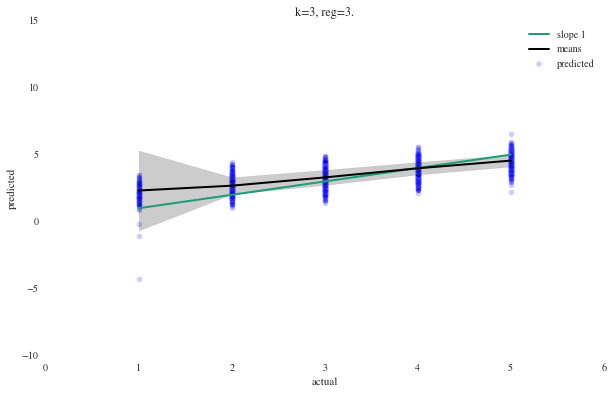

In [42]:
print ("k=3, reg=3.")
make_results_plot(smalldf,3,3.)
plt.title("k=3, reg=3.")

#### The more closer is 'slope1' to the mean line better are the results.

k=10, reg=3
fraction between -15 and 15 rating 0.993349553933


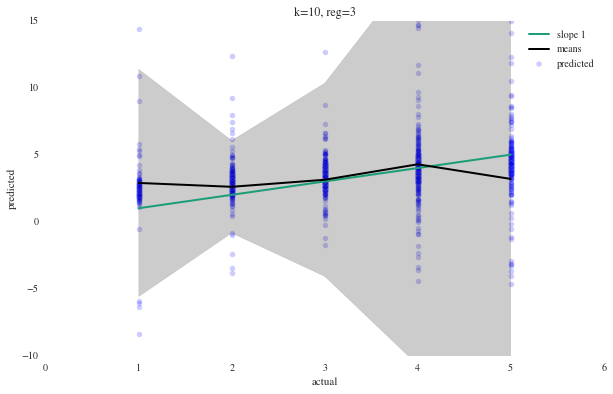

In [43]:
print ("k=10, reg=3")
make_results_plot(smalldf, 10, 3.)
plt.title("k=10, reg=3")

k=3, reg=10
fraction between -15 and 15 rating 0.999675587997


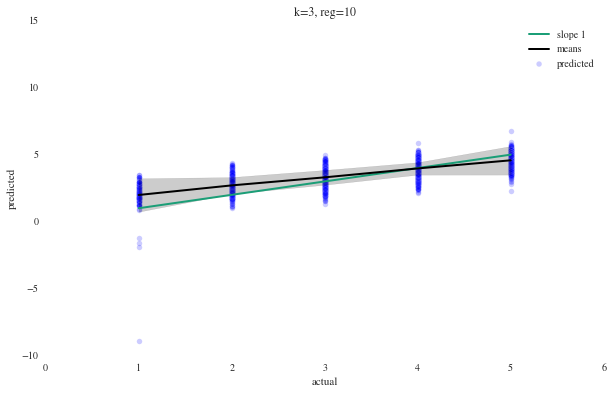

In [44]:
print ("k=3, reg=10")
make_results_plot(smalldf, 3, 10.)
plt.title("k=3, reg=10")

k=10, reg=10
fraction between -15 and 15 rating 0.99399837794


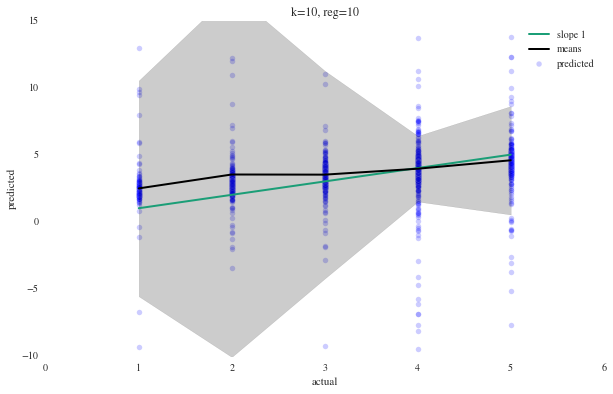

In [45]:
print ("k=10, reg=10")
make_results_plot(smalldf, 10, 10.)
plt.title("k=10, reg=10")

k=10, reg=10
fraction between -15 and 15 rating 1.0


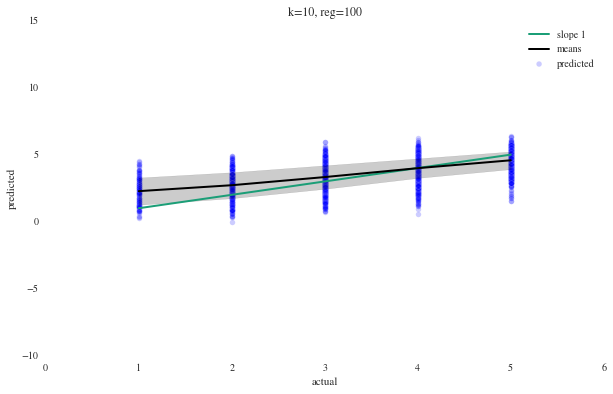

In [47]:
print ("k=10, reg=10")
make_results_plot(smalldf, 1, 0.)
plt.title("k=10, reg=100")

For k=3, the predicted values are quite well-behaved, with the exception of several predictions that have extremely large magnitudes. It appears that the predicted values are pulled into the mean star rating, which sits somewhere around 3.8, so ratings on the low end are overestimated, and similarly ratings on the high end underestimated. The regularization does not appear to have a strong effect when k = 3.

For k=10, the predicted values are much less stable, with many more extreme predictions. The means appear to track better with the true means. The regularization has a much more extreme, although indirect, effect on the appearance of the plot. Since regularization has stronger effects on similarity scores between restaurants that have small common support, we can see that increasing k makes the predictions more sensitive to the regularization because in a small dataset, the common support between a restaurant and it's 10-nearest one will be quite small.

Note that this example does not seem to follow the standard bias-variance tradeoff, where we would expect small k to give a unbiased estimates that capture the extremes, while we would expect large k to give biased estimates that pull extreme values toward the mean. A large reason for this failure for this example to capture this behavior is that we have defined similarity scores that can be positive or negative, and the bias-variance logic is based on the more standard setting where we average together values that have strictly positive weights. When you have negative weights, it's possible that the sum of sijsij's in a neighborhood can get close to zero, making our estimator Ŷ umY^um explode in the positive or negative direction since this would entail dividing by (nearly) zero. Thus for those restaurants where the denominator goes to 0 (more likely to happen at larger k as you have more chances of it there being more weights to add), the ratings are unstable, even numerically!

#### We can use cross validation to choose the perfect k

## Bayesian Chocolates: Model based recommendations

In [154]:
import urllib
import urllib.request


url = "http://sports.williamhill.com/bet/en-gb/betting/y/5/cp/554/Football.html"
page = urllib.request.urlopen(url)

from bs4 import BeautifulSoup

soup = BeautifulSoup(page, "html.parser")



In [182]:
right_table=soup.find('table', class_='tableData')

A=[]
B=[]
C=[]
D=[]
E=[]
F=[]
G=[]


"""for row in right_table.find_all("tr"):
    for cells in row.find_all('td'):
        A.append(cells[0].find(Text=True))
        B.append(cells[1].find(Text=True))
        C.append(cells[2].find(text=True))
        D.append(cells[3].find(text=True))
        E.append(cells[4].find(text=True))
        F.append(cells[5].find(text=True))
        G.append(cells[6].find(text=True))

import pandas as pd

df=pd.DataFrame(A,columns=['test'])
df['test1']=B
df['test2']=C
df['test3']=D
df['test4']=E
df['test5']=F
df['test6']=G

print(df)"""
k = []
for row in right_table.find_all("tr"):
    for cells in row.find_all('td'): 
         print (cells.)

<td class="leftPad" scope="col">
<span id="tzTime:br:1471096800:br:dd_MMM:br:1">13 Aug</span>
</td>
<td class="leftPad" scope="col">
<span id="tzTime:br:1471096800:br:HH:mm_C:br:2">15:00 UK</span>
</td>
<td class="leftPad" scope="col">
<a href="http://sports.williamhill.com/bet/en-gb/betting/e/9464609/Arsenal+v+Liverpool.html"><span id="9464609_mkt_namespace">Arsenal   v   Liverpool</span></a>
</td>
<td scope="col">
</td>
<td scope="col">
<div class="eventpriceholder-left" id="ip_oddsBtn_1229502658" onclick="document.betslip.add_leg(this,'','L','23','20','','','1229502658')" onmouseout="removeClass(this, 'pricemouseover'); return false" onmouseover="addClass(this, 'pricemouseover'); return false">
<div class="eventprice" id="ip_selection1229502658price">
			
			
				
					23/20
				
			
			
		</div>
<div class="clearBoth"></div>
</div>
</td>
<td scope="col">
<div class="eventpriceholder-left" id="ip_oddsBtn_1229502659" onclick="document.betslip.add_leg(this,'','L','23','10','','','1229